In [1]:
import pandas as pd
df = pd.read_csv('data//All_tweets_public.csv')

In [2]:
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Custom stop words
custom_stopwords = set(stopwords.words('english'))
additional_stopwords = {'xexxa', 'ba', 'bwildfire', 'bcalifornia', 'bthe', 'itxexxs', 'b','donxexxt', 'ixexxm'} 
custom_stopwords.update(additional_stopwords)

custom_stopwords = list(custom_stopwords)


# Comprehensive function to preprocess the text data
def preprocess_text(text):
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Step 2: Remove special characters, numbers, and punctuation
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Step 3: Convert to lowercase
    text = text.lower()
    
    # Step 4: Apply spaCy's NLP pipeline (tokenization, lemmatization, and stopword removal)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    # Step 5: Remove custom stopwords
    tokens = [token for token in tokens if token not in custom_stopwords]
    
    # Join tokens back to a single string
    return " ".join(tokens)

# Apply the preprocessing function to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msarv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


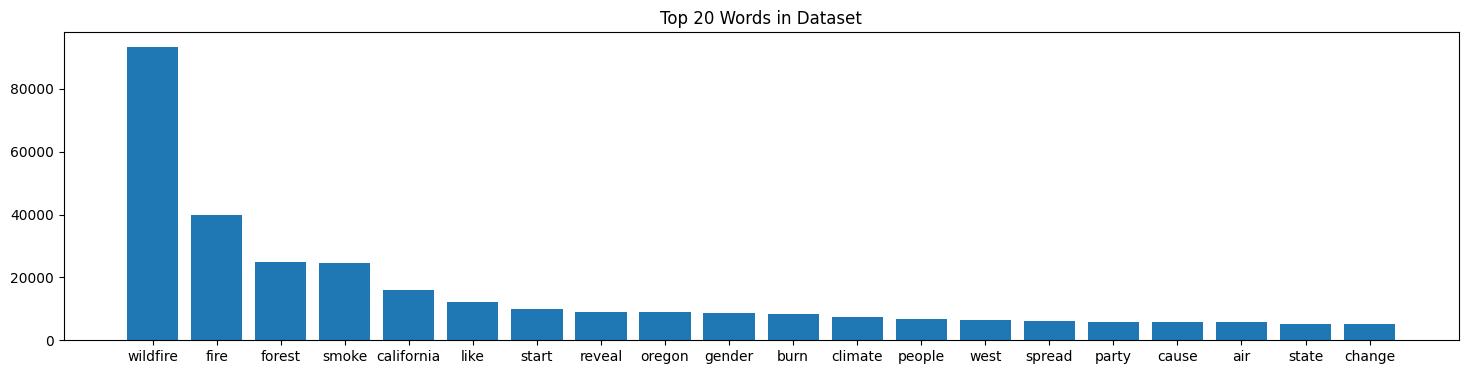

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

# Convert bytes to string and preprocess
df['Processed_Text'] = df['Processed_Text'].astype(str)

# Tokenize the text data
df['tokenized_text'] = df['Processed_Text'].str.split()

# Flatten all tokenized words into a single list
all_words = [word for tokens in df['tokenized_text'] for word in tokens]

# Get word frequencies
word_counts = Counter(all_words)

# Plotting word frequencies
plt.figure(figsize=(18, 4))
plt.bar(*zip(*word_counts.most_common(20)))
plt.title('Top 20 Words in Dataset')
plt.show()

# Identify common words and update the stop words list
common_words = [word for word, freq in word_counts.most_common(50)]
#custom_stopwords.extend(common_words) 



In [4]:
print(custom_stopwords)

['him', 'didn', 'no', 'her', 's', 'those', 'such', 'do', 'too', 'hers', 'now', 'is', "you're", 'themselves', 'between', 'out', 'how', 'with', 'can', 'until', 'both', 'nor', 'shouldn', "shan't", 'here', 'was', 'from', 'she', 'or', 't', 'any', 'we', 'having', 'after', "you've", 'it', 'bthe', 'my', 'a', 'to', 'ourselves', 'i', 'but', 've', "won't", 'few', 'again', 'own', 'an', 'very', 'and', 'd', 'ours', 'yours', 'down', 'same', 'hasn', 'myself', 'been', 'don', 'wasn', 'doing', 'which', 'on', 'under', 'when', 'weren', 'of', "it's", 'needn', 'as', 'ma', 'herself', 'won', 'doesn', 'them', "didn't", 'mightn', 'xexxa', 'b', 'about', 'other', 'if', 'by', 'in', 'your', 'all', 'couldn', 'these', 'up', "you'll", 'below', 'then', "hasn't", 'am', 'm', 'his', 'yourself', 'yourselves', 'does', "doesn't", 'he', "should've", 'itself', "haven't", 'what', 'through', 'himself', "mightn't", "shouldn't", "wasn't", 'should', "needn't", 'each', 'ba', 'o', 'did', 'being', 'not', 'have', 'were', 'its', 'during'

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words=custom_stopwords)
X = vectorizer.fit_transform(df['Processed_Text'])

# Document the number of words after filtering
print(f"Number of words after filtering: {len(vectorizer.get_feature_names_out())}")


Number of words after filtering: 36433


In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, learning_decay=0.7, random_state=42)
lda.fit(X)

# Evaluate with perplexity
print(f"Model Perplexity: {lda.perplexity(X)}")


# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top 10 words for each topic
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)




Model Perplexity: 2278.8642779026386
Topic 1:
wildfire, smoke, air, west, coast, sky, quality, season, california, today
Topic 2:
wildfire, california, oregon, reveal, gender, home, party, burn, firefighter, spark
Topic 3:
wildfire, climate, change, trump, california, state, arson, boregon, oregon, science
Topic 4:
wildfire, like, spread, start, gender, reveal, know, think, people, bi
Topic 5:
fire, forest, burn, wildfire, national, management, county, tree, california, year


In [ ]:
# from gensim import corpora
# from gensim.models import CoherenceModel

# # Assuming 'texts' is the preprocessed text data tokenized into words
# # Example: df['Processed_Text'].apply(lambda x: x.split())

# # Convert the processed text data into a list of lists of words
# texts = df['Processed_Text'].apply(lambda x: x.split()).tolist()

# # Create a Gensim dictionary from the texts
# dictionary = corpora.Dictionary(texts)

# # Create a corpus using the dictionary
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Extract topics from the LDA model
# n_top_words = 10  # Adjust the number of top words as needed
# topics = []
# for topic_idx, topic in enumerate(lda.components_):
#     top_words = [dictionary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
#     topics.append(top_words)

# # Calculate coherence score
# coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_score = coherence_model.get_coherence()
# print(f"Coherence Score: {coherence_score}")


In [7]:
import pyLDAvis.lda_model

# Visualize LDA topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')
pyLDAvis.display(panel)


In [8]:
# Save the visualization as an HTML file
pyLDAvis.save_html(panel, 'lda_visualization.html')